In [11]:
import igraph as ig
import leidenalg as la
import numpy as np
import networkx as nx
import json
import random

In [4]:
n = 50
q_con = 0.4
q_mod = 0.7
Path = "./Example_data/nG"+str(n)
edges = []
adj = np.zeros((n,n))
with open(Path + "/nx_run=1_qmod="+str(q_mod) +"_qcon="+ str(q_con) + "_n="+str(n), mode="r") as fp:
    for count, line in enumerate(fp):
        # start from node 0
        edges.append(tuple([eval(x) - 1 for x in line[:-1].split(" ")]))
        adj[edges[-1][0], edges[-1][1]] = adj[edges[-1][1], edges[-1][0]] = 1

In [5]:
g = ig.Graph()
g.add_vertices(n)
g.add_edges(edges)
# partition = la.find_partition(g, la.RBConfigurationVertexPartition, resolution_parameter = 4)
partition = la.find_partition(g, la.RBConfigurationVertexPartition, resolution_parameter = 2)
groups = np.array(partition.membership)
n_clusts = np.max(groups)+1
n_clusts

8

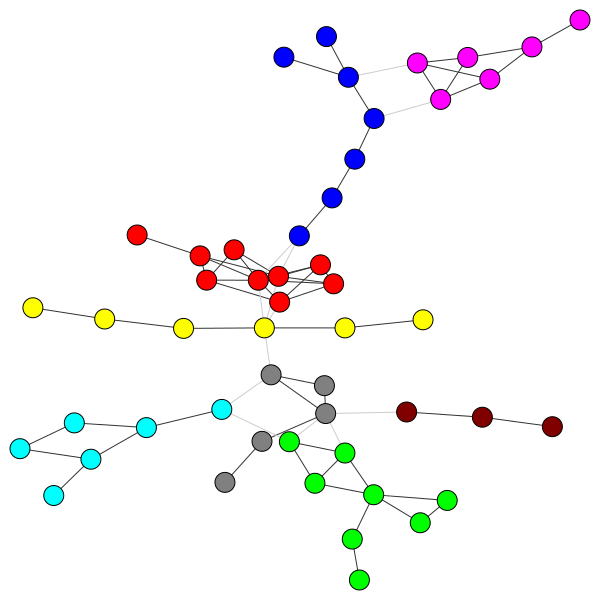

In [6]:
ig.plot(partition)

In [7]:
for i in range(n_clusts):
    part_i = np.where(groups == i)[0] 
    print('group size:', len(part_i))

group size: 9
group size: 8
group size: 7
group size: 6
group size: 6
group size: 6
group size: 5
group size: 3


In [9]:
def find_shuffle(n_clusts, groups, num = 10):
    shuffles = []
    from itertools import permutations
    permute = list(np.arange(n_clusts))
    count = 0

    intersection = [[[] for x in range(n_clusts)] for x in range(n_clusts)]
    # find intersection
    for i in range(n_clusts):
        for j in range(i + 1, n_clusts):
            group_i = np.where(groups == i)[0]
            group_j = np.where(groups == j)[0]
            row, col = np.where(adj[group_i,:][:,group_j] != 0)
            # partition into two equal size, first part small, second part large
            intersection[i][j] = intersection[j][i] =  [x for x in row] + [x for x in col]      

    # find three solutions
    while count < num:
        shuffles.append([])
        
        # starting cluster for search
        selection_pool = set(np.arange(n_clusts))
        random.seed(count*2)
        start_clust = count * 3 #random.choice(np.arange(n_clusts))
        shuffles[-1].append(start_clust)
        selection_pool = selection_pool - set(shuffles[-1]).intersection(selection_pool) 
        # print(selection_pool)

        while len(selection_pool) != 0:
            for curr_clust in set(np.arange(n_clusts)) - selection_pool:
                next_clusts = [x for x in range(n_clusts) if len(intersection[curr_clust][x]) != 0 and x in selection_pool]
                shuffles[-1].extend(next_clusts)
                # eliminate the selected clusters
                selection_pool = selection_pool - set(shuffles[-1]).intersection(selection_pool) 
        count += 1
    return intersection, shuffles

In [23]:
_, shuffled_groups = find_shuffle(n_clusts, groups, num = 3)
np.savetxt("./Example_data/nG50/shuffled_groups.csv", np.array(shuffled_groups).astype(int), delimiter=',')
shuffled_groups = np.genfromtxt('./Example_data/nG50/shuffled_groups.csv',delimiter= ',').astype(int)
shuffled_groups = shuffled_groups[1]
# shuffled_groups = [2, 5, 0, 3, 6, 1, 4, 7]

In [24]:
shuffled_groups

array([3, 0, 6, 2, 1, 5, 7, 4])

In [25]:
last_nodes = []
start_nodes = []
for idx, group in enumerate(shuffled_groups):
    results = {}
    curr_group = np.where(groups == group)[0]
    # document start nodes for the group 
    start_nodes.append([])
    # document all nodes for the group
    last_nodes.append([])
    print('group id:', shuffled_groups[idx])

    for idx2, pre_group in enumerate(last_nodes[:-1]):
        # find intersection nodes between current group and previous group
        row, col = np.where(adj[curr_group,:][:,pre_group] != 0)
        intersection_nodes = np.unique(np.array(pre_group)[col])
        print("intersection nodes w.r.t previous group", shuffled_groups[idx2], 'is', intersection_nodes)
        start_nodes[-1] = list(set(start_nodes[-1]) | set(intersection_nodes))
    
    # incorporating start nodes into current groups
    # last_nodes[-1].extend(list(set(curr_group) | set(start_nodes[-1])))

    # simple version only incorporate one start node
    if len(start_nodes[-1]) != 0:
        # make stable
        anchor = start_nodes[-1][0]
        dup = curr_group[np.where(adj[curr_group,anchor] != 0)[0][0]]
        start_nodes[-1] = [anchor, dup]
    print("start nodes", start_nodes[-1], "number", len(start_nodes[-1]))
    
    curr_group = list(set(curr_group) - set(start_nodes[-1]))
    last_nodes[-1].extend(list(start_nodes[-1]) + list(curr_group))
    assert len(np.unique(np.array(last_nodes[-1]))) == len(last_nodes[-1])
    print("all nodes", last_nodes[-1], "number", len(last_nodes[-1]))
    print()

    # store the results into dictionary, start from 0
    results['start_nodes'] = [int(x) for x in start_nodes[-1]]
    results['last_nodes'] = [int(x) for x in last_nodes[-1]]
    # index start from 0
    adj_start = adj[start_nodes[-1],:][:,start_nodes[-1]]
    adj_last = adj[last_nodes[-1],:][:,last_nodes[-1]]

    print("adj after")
    print(adj_start)
    print()
    print(adj_last)
    print()

    # save into results
    results['first_graph'] = []
    results['last_graph'] = []
    row, col = np.where(adj_start != 0 )
    for edge in zip(row,col):
        edge = [int(x) for x in edge]
        # node start from 1
        edge[0] = edge[0] + 1
        edge[1] = edge[1] + 1
        results['first_graph'].append(tuple(edge))

    row, col = np.where(adj_last != 0 )
    for edge in zip(row,col):
        edge = [int(x) for x in edge]
        # node start from 1
        edge[0] = edge[0] + 1
        edge[1] = edge[1] + 1
        results['last_graph'].append(tuple(edge))
    
    # save the results into json
    import json
    with open(Path + '/group'+str(idx) + '.json','w') as fp:
        json.dump(results, fp)

group id: 3
start nodes [] number 0
all nodes [34, 3, 18, 39, 25, 11] number 6

adj after
[]

[[0. 1. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]

group id: 0
intersection nodes w.r.t previous group 3 is [3]
start nodes [3, 2] number 2
all nodes [3, 2, 37, 40, 9, 12, 44, 22, 29, 31] number 10

adj after
[[0. 1.]
 [1. 0.]]

[[0. 1. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 1. 1. 0.]]

group id: 6
intersection nodes w.r.t previous group 3 is [3]
intersection nodes w.r.t previous group 0 is [3]
start nodes [3, 19] number 2
all nodes [3, 19, 1, 20, 45, 7] number 6

adj after
[[0. 1.]
 [1. 0.]]

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1